# Energy Price Forecasting in Spain


## Setup 

We start by importing the necesary libraries and defining a couple of helper functions for testing our models.

In [88]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# import pickle
import cloudpickle as pickle
import numpy as np
from datetime import timedelta
import seaborn as sns
import re

# pyro imports
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDelta, AutoNormal, AutoDiagonalNormal
import pyro.poutine as poutine
from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps
from pyro.infer.reparam import LocScaleReparam, AutoReparam
from pyro.ops.stats import quantile

# seeds for reproducibility
seed = 20220527
pyro.set_rng_seed(seed)
torch.manual_seed(seed)

# set plotting style to seaborn
plt.style.use('seaborn')

### Helper functions

Here we define some helper functions that we will use throughout the notebook.

In [ ]:
def get_weather_data(df):
    """Extract the columns that are the weather data we would like to use"""
    return df[['temp', 'temp_min','temp_max','pressure','humidity','wind_speed','wind_deg','rain_1h','rain_3h','snow_3h']].copy()

def get_energy_data(df):
    """Extract the columns that are the energy data we would like to use"""
    return  df[['generation biomass','generation fossil', 'generation hydro', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar',
        'generation total', 'generation waste', 'generation wind onshore']].copy()

def train(model, num_steps, model_name = None, save = False, **kwargs):
    """Create and train a forecasting model"""
    pyro.set_rng_seed(1)
    pyro.clear_param_store()
    model = model()
    guide = AutoNormal(model)

    # create the forecasting model
    forecaster = Forecaster(
        model,
        y[:T1],
        covariates[:T1],
        learning_rate=0.1,
        learning_rate_decay=0.05,
        num_steps=num_steps,
        guide = guide,
        **kwargs
    )

    # save the forecasting model
    if save:
        model_name = str(forecaster.model).strip("()") if model_name is None else model_name
        with open(f"models/{model_name}.pkl", "wb") as f:
            pickle.dump(forecaster, f)

        # forecaster._save_to_state_dict()

    return forecaster

def load_forecaster(model_name):
    """Load a saved forecasting model"""
    with open(f"models/{model_name}.pkl", "rb") as f:
        forecaster = pickle.load(f)
    return forecaster


def sample_from_posterior(forecaster, num_samples = 100):
    """Draw samples from the posterior of a forecasting model"""
    forecaster = load_forecaster(forecaster) if isinstance(forecaster, str) else forecaster
    guide = forecaster.guide()
    # guide = AutoNormal(forecaster.model())

    # pyro.set_rng_seed(1)
    # pyro.clear_param_store()
    # model = forecaster.model
    # guide = AutoNormal(model)
    
    with poutine.trace() as tr:
        forecaster(y[:T1], covariates, num_samples=num_samples)

    # extract the values from the recorded trace
    posterior_samples = {
        name: site["value"]
        for name, site in tr.trace.nodes.items()
        if site["type"] == "sample"
    }

    return posterior_samples

def test_implementation(forecaster, start_idx = 0, end_idx = -1, ax = None):
    """
    Test the model implementation by extracting the posterior samples and plotting the results.
    """
    pred = sample_from_posterior(forecaster, 100)['prediction'].squeeze(-1).mean(0)
    resid = obs -pred

    # plot
    ax = plt if ax is None else ax
    ax.plot(dates, y, label="observed", alpha= .7)
    ax.plot(dates[:T1], pred[:T1], label="train prediction", alpha = .7)
    ax.plot(dates[T1:], pred[T1:], label="test prediction", alpha = .7)
    ax.plot(dates, resid, label="residuals", alpha = .7)
    ax.legend()

    y_min = min(pred[start_idx:end_idx].min(), resid[start_idx:end_idx].min())
    y_max = max(pred[start_idx:end_idx].max(), resid[start_idx:end_idx].max())
    date_margin = timedelta(days=4)

    if ax == plt:
        ax.xlim(dates[start_idx]- date_margin, dates[end_idx] + date_margin)
        ax.ylim(y_min -0.1*np.abs(y_min), y_max + 0.1*y_max)
        ax.title("Forecast with " + str(forecaster.model).strip("()"))
    else:
        ax.set_xlim(dates[start_idx]- date_margin, dates[end_idx]+ date_margin)
        ax.set_ylim(y_min -0.1*np.abs(y_min), y_max + 0.1*y_max)
        ax.set_title("Forecast with " + str(forecaster.model).strip("()"))
        plt.setp(ax.get_xticklabels(), rotation = 45)

    # print residuals
    print("Mean price: ", obs.mean())
    print("Mean abs residual: ", resid.abs().mean())
    print("Mean abs train residual: ", resid[:T1].abs().mean())
    print("Mean abs test residual: ", resid[T1:].abs().mean())

# posterior_samples = {model : sample_from_posterior(model) for model in models}
# sample_from_posterior("LinearDLM")
# forecaster = load_forecaster("LinearDLM")

In [71]:
# forecaster.guide()
# Forecaster._load_from_state_dict(forecaster, forecaster.state_dict, None, None, False, None, None, None)
# forecaster.state_dict

TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'

## Data

The data used for this project has been found on [Kaggle](https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather) and consists of two .csv files containing the weather and energy data for Spain for the years 2015-2018 on an hourly basis. The data has been cleaned and preprocessed in the previous assignment (see data.ipynb) and we will therefore use this as our starting point. To reduce the number of observations and speed up computation time we will aggreagate the data on daily level. This also makes more sense with regards to the goal of forecasting the energy price.

Furthermore, we split the data into a training set and a test set with a 90-10 split. Here we ensure that the test set contains the last 10 \% of the data as we are dealing with a time series and therefore cannot assume independence between observations, making the last 10 \% of the best representation of the future observations.

In [72]:
# set variables describing how much data to use
T = None # number of time steps to include, if None all data is used
test_frac = 0.1 # fraction of data to use for testing
aggregation_level = "D" # aggregation level of the data, D = daily, W = weekly, M = monthly

# read the data that has previously (in last assignment, see data notebook) been preprocessed
df = pd.read_csv("preprocessed_data/df.csv")
df["time_str"] = [d.split("+")[0] for d in df["time_str"]]
df["time_str"] = pd.to_datetime(df["time_str"], infer_datetime_format=True)

# group by date and take the mean as we have multiple measurements per day due to having data from 5 different cities in Spain
df = df.groupby("time_str").mean()
df = df.reset_index().set_index('time_str')
df.index.name = None

# aggregate data, can be commented out to use all data
# df = df.asfreq(aggregation_level) 
df = df.resample(aggregation_level).mean()
# df = df.groupby(df.index.date).mean().reset_index()

# extract the columns that we would like to use
dfW = get_weather_data(df)
dfE = get_energy_data(df)

# define start, train end, test end
n = len(df) if T is None else T
T0 = 0
T1 = n - int(test_frac*n) # 10 % test data
T2 = n
print("Number of observations:", n)
print("Number of training observations:", T1 - T0)
print("Number of test observations:", T2 - T1)


# standardize data
df_standardized = dfE.merge(dfW, left_index=True, right_index=True)
df_standardized["price_ actual"] = df["price actual"]
scaler = StandardScaler().fit(df_standardized[:T1])
df_standardized = scaler.transform(df_standardized)
df_standardized = pd.DataFrame(df_standardized, columns=list(dfE.columns) + list(dfW.columns) + ["price_actual"], index = df.index)

# create tensors
X_W = torch.from_numpy(df_standardized[dfW.columns].values).float()
X_E = torch.from_numpy(df_standardized[dfE.columns].values).float()
obs = torch.from_numpy(df_standardized["price_actual"].values).float()

# translate to pyro forecasting language
y = obs.unsqueeze(-1) if T is None else obs[-T:].unsqueeze(-1)
covariates = torch.hstack((X_E, X_W)) if T is None else torch.hstack((X_E, X_W))[-T:]

# define constants
n, p = covariates.shape
dates = df.index[-n:] # used for plotting



Number of observations: 1462
Number of training observations: 1316
Number of test observations: 146


### Standardized observations

We now take a look at what the standardized observations look like. Here we split the plot into the regressors (weather and energy generation) and the response (energy price), as the response variable deserves the most attention. Looking at the table below we do not see a mean of 0 and a standard deviation of 1. This is because the data is standardized wrt. the 2nd order moments of the training data and the test test data will therefore cause deviations.

In [11]:
print("Standardized data:")
display(df_standardized.describe())

print("Original data:")
display(pd.DataFrame(scaler.inverse_transform(df_standardized), columns=df_standardized.columns, index = df_standardized.index).describe())


Standardized data:


,generation biomass,generation fossil,generation hydro,generation nuclear,generation other,generation other renewable,generation solar,generation total,generation waste,generation wind onshore,...,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,price_actual
count,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,...,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000
mean,-0.057090,0.016614,-0.018529,-0.005190,-0.020133,0.099148,-0.039160,-0.004833,0.070821,-0.002637,...,0.014147,-0.001702,-0.004031,0.042986,-0.017126,-0.012666,-0.020022,-0.022876,-0.005860,0.115502
std,0.973799,0.983844,0.976914,1.001314,0.960847,1.005120,0.999370,0.995085,0.983116,0.998847,...,1.003859,0.989939,0.949158,1.006344,0.969423,0.987080,0.965597,0.951572,0.949243,1.019988
min,-2.370157,-2.006389,-1.528920,-3.104093,-2.693211,-2.339002,-2.003894,-2.543451,-3.139880,-1.637611,...,-2.533830,-2.726863,-0.065671,-2.814550,-1.586099,-3.169459,-0.541161,-0.230459,-0.058683,-3.552849
25%,-0.632179,-0.808071,-0.703486,-0.627680,-0.357681,-0.846163,-0.903605,-0.684283,-0.479581,-0.805593,...,-0.823761,-0.801288,-0.043983,-0.712649,-0.627779,-0.683177,-0.523350,-0.230459,-0.058683,-0.481603
50%,-0.266500,0.065943,-0.273572,0.375419,-0.149646,0.281933,-0.107313,-0.051511,0.284102,-0.217494,...,-0.051838,-0.088068,-0.041276,0.004451,-0.246996,-0.158798,-0.380870,-0.230459,-0.058683,0.175828
75%,0.566699,0.725898,0.377195,0.888959,0.941950,0.944608,0.863510,0.619906,0.869804,0.579937,...,0.925750,0.817202,-0.038560,0.799121,0.315794,0.524771,0.088128,-0.230459,-0.058683,0.844227
max,2.170632,3.285355,2.980031,1.033935,1.731896,2.056899,1.807150,3.086041,1.596735,3.283147,...,2.197744,2.063985,31.624385,2.779050,7.253109,3.546384,12.602663,10.457986,29.266394,3.590981


Original data:


,generation biomass,generation fossil,generation hydro,generation nuclear,generation other,generation other renewable,generation solar,generation total,generation waste,generation wind onshore,...,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,price_actual
count,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,...,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1.462000e+03,1462.000000,1462.000000,1462.000000
mean,383.595163,10625.029339,4052.866310,6264.376407,60.216212,85.631762,1431.540956,28638.758126,269.388059,5466.113918,...,288.384954,291.133867,1070.168379,68.227925,2.467447,166.591701,7.315224e-02,0.000386,0.004830,57.889006
std,83.468016,3576.941206,1841.501723,817.303217,19.533126,13.366456,703.235263,2974.013611,48.715303,2898.627811,...,6.261760,6.772020,1359.709609,9.506736,0.952175,35.969153,1.355410e-01,0.001767,0.086791,12.060290
min,185.333333,3270.041667,1205.750000,3734.958333,5.875000,53.208333,49.000000,21051.583333,110.291667,721.458333,...,272.491463,272.491463,981.866667,41.233333,0.926389,51.558333,1.387779e-17,0.000000,0.000000,14.514583
25%,334.302083,7626.739583,2761.708333,5756.281250,53.354167,73.060662,823.250000,26608.083333,242.114583,3135.956069,...,283.158343,285.664025,1012.934474,61.089583,1.867659,142.158333,2.500000e-03,0.000000,0.000000,50.828854
50%,365.645833,10804.375000,3572.104167,6575.041667,57.583333,88.062500,1383.583333,28499.250000,279.956522,4842.604167,...,287.973361,290.543056,1016.812500,67.863889,2.241667,161.266667,2.250000e-02,0.000000,0.000000,58.602292
75%,437.062500,13203.760417,4798.812500,6994.208333,79.774457,96.875000,2066.730978,30505.916667,308.979167,7156.729167,...,294.071252,296.735866,1020.704167,75.370982,2.794444,186.175893,8.833333e-02,0.000000,0.000000,66.505417
max,574.541667,22509.125000,9705.208333,7112.541667,95.833333,111.666667,2730.750000,37876.458333,345.000000,15001.375000,...,302.005556,305.264917,46379.216667,94.075000,9.608333,296.283333,1.845000e+00,0.019850,2.681250,98.982917


#### Regressor plots (weather and energy generation)

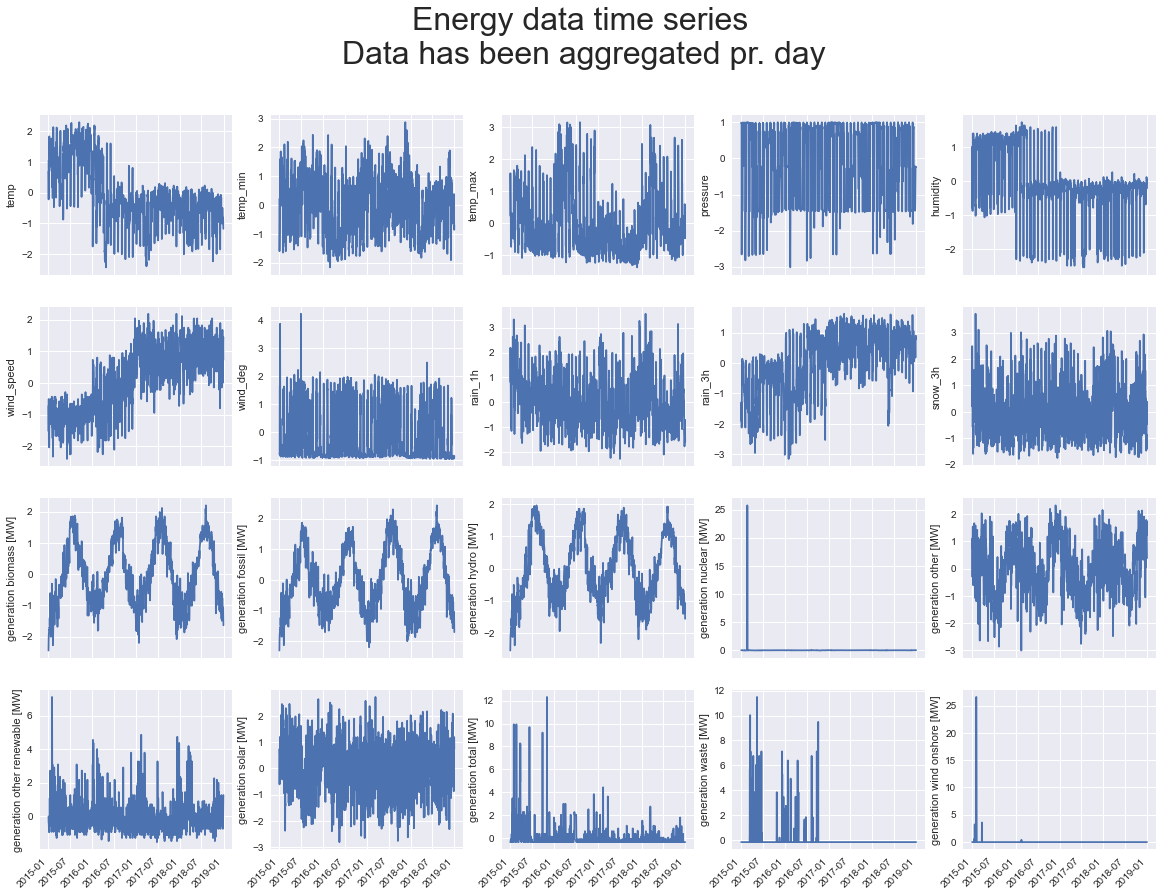

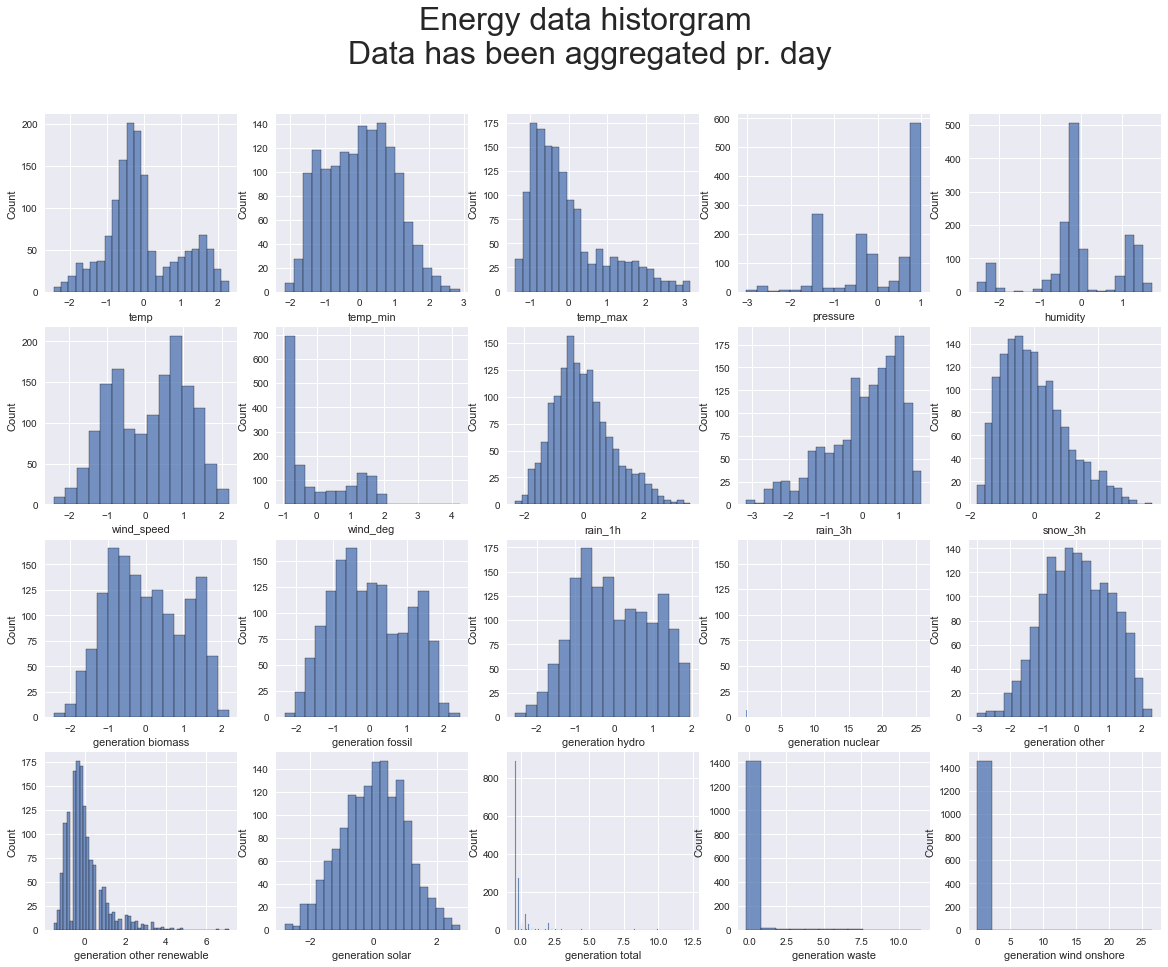

In [42]:
fig, ax = plt.subplots(4,5, figsize = (20,15))
fig2, ax2 = plt.subplots(4,5, figsize = (20,15))

# plot titles
fig.suptitle("Energy data time series\n Data has been aggregated pr. day", size = 32)
fig2.suptitle("Energy data historgram\n Data has been aggregated pr. day", size = 32)

# aggregate time series
ts_agg = df_standardized.iloc[:, df_standardized.columns != "price_actual"]  #.asfreq("D") 

i = 0
for col_name in ts_agg.columns:
    # time series plot
    if re.findall("generation", col_name):
        ax[i//5, i%5].set_ylabel(col_name + " [MW]")  
    else:
        ax[i//5, i%5].set_ylabel(col_name)  
    plot = ax[i//5, i%5].plot(ts_agg.index, ts_agg[col_name])
    fig.autofmt_xdate(rotation=45)

    # dist plot
    sns.histplot(ts_agg[col_name], ax = ax2[i//5, i%5])

    # update axis index
    i += 1

#### Response plots (energy price)


c:\Users\lukas\Git\Studie\42186-MBML-Project\MBML-env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Density distribution of standardized price')

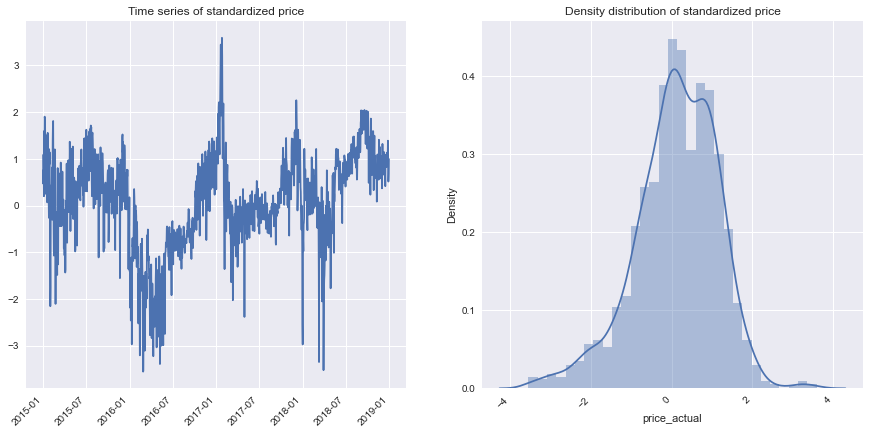

In [5]:
y = df_standardized["price_actual"]

fig, ax = plt.subplots(1,2, figsize = (15,7.5))

# time series plot
ax[0].plot(dates, y)
fig.autofmt_xdate(rotation=45)
ax[0].set_title("Time series of standardized price")

# dist plot
sns.distplot(y, ax = ax[1])
ax[1].set_title("Density distribution of standardized price")

plt.show()

## Models and Variational Inference (training)

We are now ready to have a look at implementing a model. The original idea as presented in milestone assignment was to implement SLDS with an extended Kalman resulting in the generative process:

>1. For each season $m \in \{1,\ldots, M\}$
>>    a) Draw $\boldsymbol{\theta}_{f,m} \sim \mathcal{N}(\boldsymbol{\theta}_f|\mathbf{0}, \lambda_f\mathbf{I})$ <br>
>>    b) Draw $\boldsymbol{\theta}_{g,m} \sim \mathcal{N}(\boldsymbol{\theta}_g|\mathbf{0}, \lambda_g\mathbf{I})$<br>
>>    c) Draw $\mathbf{R}_m \sim \mathcal{N}(\mathbf{R} | \mathbf{0}, \gamma\mathbf{I})$<br>
>>    d) Draw $\sigma \sim \mathcal{I}\mathcal{G}(\sigma|\tau)$<br>
>>    e) Draw $\beta_m \sim \mathcal{N}(\beta_m|\mathbf{0}, \sigma_\beta^2\mathbf{I})$<br>
>2. For each time $t \in \{1,\ldots, T\}$ <br>
>>   a) Draw season variable $z_t \sim \text{Multinomial}(z_t | \text{Softmax}(X_t^W, \beta_1,\ldots, \beta_M))$<br>
>>    b) Draw hidden state for season $z_t$ $\mathbf{h_t^{z_t}} \sim \mathcal{N}(\mathbf{h_t^{z_t}}| f\left(\mathbf{h_{t-1}^{z_{t-1}}}, \mathbf{X_t}, \boldsymbol{\theta}_{f,z_t}\right), \mathbf{R}_m)$<br>
>>    c) Draw price $y_t \sim \mathcal{N}(y_t|g(\mathbf{h_t^{z_t}}, \boldsymbol{\theta}_{f,z_t}), \sigma^2)$<br>


This proved to be rather difficult due to several reasons:

- Lack of documentation in Pyro and har to debug error messages.
- Input data in the Forecasting model has changing dimensions depending on the use of the model (e.g. a batch size is introduced when sampling from the posterior).


In [87]:
# !python -m pip install cloudpickle

You should consider upgrading via the 'c:\Users\lukas\Git\Studie\42186-MBML-Project\MBML-env\Scripts\python.exe -m pip install --upgrade pip' command.


### Linear DLM

INFO 	 step    0 loss = 350.677


Mean price:  tensor(0.1155)
Mean abs residual:  tensor(0.6754)
Mean abs train residual:  tensor(0.6742)
Mean abs test residual:  tensor(0.6866)


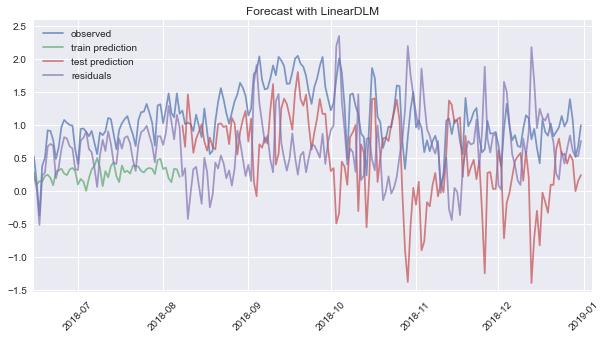

CPU times: total: 3.92 s
Wall time: 899 ms


In [89]:
%%time
class LinearDLM(ForecastingModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.tau = 1
        self.M = 4
        self.h_dim = X_E.shape[1]
        self.gamma = 1e-6

    def model(self, zero_data, covariates):
        x_E = covariates[:, :X_E.shape[1]]
        x_W = covariates[:, -X_W.shape[1]:]
        # covariates = x_E

        data_dim = zero_data.size(-1)
        duration = zero_data.size(-2)
        feature_dim = covariates.size(-1)

        # draw parameters
        theta_g = pyro.sample("theta_g", dist.Normal(0,1).expand([feature_dim]).to_event(1))

        # draw hidden states
        with self.time_plate:  
            R = pyro.sample("R", dist.HalfCauchy(self.gamma*torch.ones(feature_dim)).to_event(1))
            h = pyro.sample("h", dist.Normal(covariates, R).to_event(1))
        pyro.deterministic("h_data", h)

        # prediction
        prediction = (theta_g*h).sum(-1, keepdim=True)
        assert prediction.shape[-2:] == zero_data.shape
        pyro.deterministic("prediction", prediction) # record in model_trace

        # add noise to prediction 
        sigma = pyro.sample("sigma", dist.HalfCauchy(self.tau).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, sigma)

        self.predict(noise_dist, prediction)

# get forecaster
LinearDLM_forecaster = train(LinearDLM, num_steps=10, save=True)
# LinearDLM_forecaster = load_forecaster("LinearDLM")

# test implementation
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
test_implementation(LinearDLM_forecaster, start_idx = T1-50, ax = ax)
plt.show()

# save posterior samples for later analysis
# LinearDLM_posterior_samples = sample_from_posterior(LinearDLM_forecaster, num_samples=10000)
# with open("posterior_samples/LinearDLM.pkl", "wb") as file:
#     pickle.dump(LinearDLM_posterior_samples, file)

# torch.save((LinearDLM_forecaster, guide), "models/test")

# LinearDLM_forecaster._save_to_state_dict("test")
# pyro
# torch.save((LinearDLM_forecaster, guide), "models/test")

### Linear DLM with hidden states

INFO 	 step    0 loss = 20.1835


Mean price:  tensor(0.1155)
Mean abs residual:  tensor(0.7393)
Mean abs train residual:  tensor(0.6977)
Mean abs test residual:  tensor(1.1146)


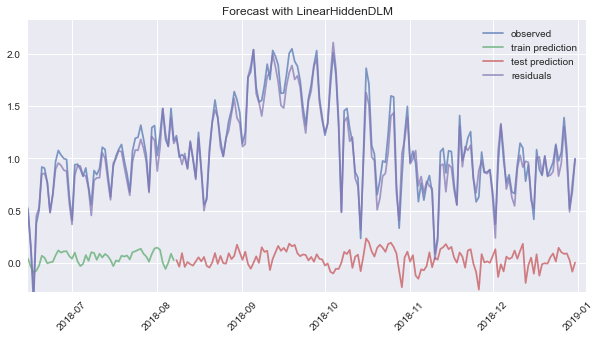

CPU times: total: 3.53 s
Wall time: 837 ms


In [90]:
%%time
class LinearHiddenDLM(ForecastingModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.tau = 1
        self.h_dim = 10
        self.gamma = 1
        self.lambda_f = 1

    def model(self, zero_data, covariates):
        x_E = covariates[:, :X_E.shape[1]]
        x_W = covariates[:, -X_W.shape[1]:]
        # covariates = x_E

        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)

        # draw parameters
        theta_g = pyro.sample("theta_g", dist.Normal(torch.zeros(self.h_dim), torch.ones(self.h_dim)).to_event(1))
        theta_f = pyro.sample("theta_f", dist.Normal(torch.zeros((feature_dim, self.h_dim)), torch.ones((feature_dim, self.h_dim)) * self.lambda_f).to_event(2))
        R = pyro.sample("R", dist.HalfCauchy(self.gamma).expand([self.h_dim]).to_event(1))

        with self.time_plate:
            
            
            # print(covariates.unsqueeze(-1).shape, theta_f.shape)
            h_mean = (theta_f*covariates.unsqueeze(-1)).sum(-2, keepdim=True).squeeze(-2)
            # print("h_mean: ", h_mean.shape, "R: ",R.shape)
            with poutine.reparam(config={"h": LocScaleReparam()}):
                h = pyro.sample("h", dist.Normal(h_mean, R).to_event(1))
        pyro.deterministic("h_data", h)

        # prediction 
        # print("theta_g: ", theta_g.shape, "h: ", h.shape)
        prediction = (theta_g*h).sum(-1, keepdim=True)
        assert prediction.shape[-2:] == zero_data.shape
        # record in model_trace
        pyro.deterministic("prediction", prediction)

        sigma = pyro.sample("sigma", dist.HalfCauchy(self.tau).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, sigma)

        self.predict(noise_dist, prediction)

# get forecaster
LinearHiddenDLM_forecaster = train(LinearHiddenDLM, num_steps=10, save=True)
# LinearHiddenDLM_forecaster = load_forecaster("LinearHiddenDLM")

# plot forecast
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
test_implementation(LinearHiddenDLM_forecaster, start_idx = T1-50, ax = ax)
plt.show()

### AR DLM

torch.Size([1315, 1])
torch.Size([1315, 1])
torch.Size([1315, 1])


INFO 	 step    0 loss = 13.0722


torch.Size([1315, 1])
torch.Size([100, 1461, 1])
Mean price:  tensor(0.1028)
Mean abs residual:  tensor(4.8063)
Mean abs train residual:  tensor(4.1104)
Mean abs test residual:  tensor(11.0742)


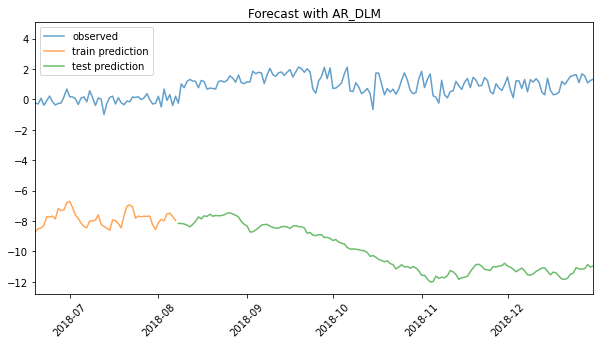

In [114]:
class AR_DLM(ForecastingModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.tau = 1
        self.h_dim = 20
        self.gamma = 1
        self.lambda_f = 1

    def model(self, zero_data, X):
        #x_E = X[:, :X_E.shape[1]]
        #x_W = X[:, -X_W.shape[1]:]

        duration, data_dim = zero_data.size()
        feature_dim = covariates.size(-1)

        #theta_f = pyro.sample("theta_f", dist.Normal(0, self.lambda_f).expand((feature_dim, self.h_dim)).to_event(2))
        #theta_g = pyro.sample("theta_g", dist.Normal(0, 1).expand(self.h_dim).to_event(1))
        alpha = pyro.sample("alpha", dist.Normal(0, 0.01).expand([feature_dim]).to_event(1))
        beta = pyro.sample("beta", dist.Normal(0, 0.01).expand([1]).to_event(1))
        gamma = pyro.sample("gamma", dist.HalfCauchy(self.tau).expand([1]).to_event(1))

        ys = []
        y = pyro.sample("y_0", dist.Normal(0, 1).expand([1]).to_event(1))
        ys.append(y)

        #y_plate = pyro.plate("y")
        for t in pyro.markov(range(duration)):
            y_mean = ys[t] + alpha @ X[t].unsqueeze(-1) + beta
            y = pyro.sample(f"y_{t+1}", dist.Normal(y_mean, torch.ones_like(y_mean) * gamma).to_event(1))
            ys.append(y)

        ys = torch.stack(ys, dim=0)[1:]
        if ys.ndim > 2:
            ys = ys.squeeze(-1).permute(1,0,2)
        print(ys.shape)
        pyro.deterministic("prediction", ys)
        #ys = ys.unsqueeze(-1)

        
        sigma = pyro.sample("sigma", dist.HalfCauchy(self.tau).expand([1]).to_event(1))

        noise_dist = dist.Normal(0, sigma)

        self.predict(noise_dist, ys)

# get forecaster
forecaster = train(AR_DLM, num_steps=2, save=True, model_name="AR_DLM")
# forecaster = load_forecaster("AR_DLM")

# plot forecast
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
eval_posterior_simple(forecaster, start_idx = T1-50, ax = ax)
plt.show()

### AR1

INFO 	 step    0 loss = 5.15054
INFO 	 step    1 loss = 4.79328
INFO 	 step    2 loss = 4.57109
INFO 	 step    3 loss = 4.22396
INFO 	 step    4 loss = 4.24503
INFO 	 step    5 loss = 4.20357
INFO 	 step    6 loss = 4.35744
INFO 	 step    7 loss = 4.32317
INFO 	 step    8 loss = 4.29237
INFO 	 step    9 loss = 4.26957


Mean price:  tensor(0.1155)
Mean abs residual:  tensor(0.6300)
Mean abs train residual:  tensor(0.5735)
Mean abs test residual:  tensor(1.1391)


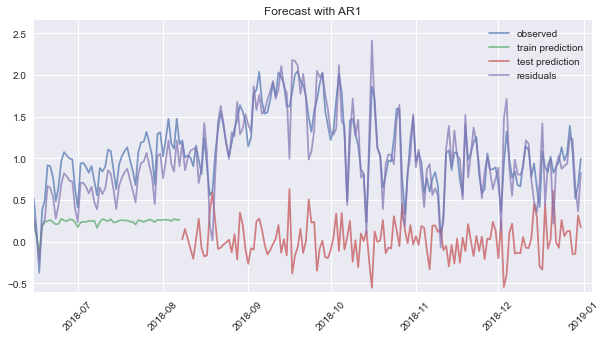

CPU times: total: 44.9 s
Wall time: 43.7 s


In [76]:
%%time
class AR1(ForecastingModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.tau = 1
        self.M = 4
        # self.h_dim = X_E.shape[1]
        self.h_dim = 20
        self.gamma = 1
        self.lambda_f = 1
        self.order = kwargs.get("order", 1)

    def model(self, zero_data, covariates):
        #x_E = X[:, :X_E.shape[1]]
        #x_W = X[:, -X_W.shape[1]:]

        duration, data_dim = zero_data.size()
        feature_dim = covariates.size(-1)

        #theta_f = pyro.sample("theta_f", dist.Normal(0, self.lambda_f).expand((feature_dim, self.h_dim)).to_event(2))
        #theta_g = pyro.sample("theta_g", dist.Normal(0, 1).expand(self.h_dim).to_event(1))
        # alpha = pyro.sample("alpha", dist.Normal(0, 0.01).expand([feature_dim]).to_event(1))
        # beta = pyro.sample("beta", dist.Normal(0, 0.01).expand([1]).to_event(1))
        gamma = pyro.sample("gamma", dist.HalfCauchy(self.tau).expand([1]).to_event(1))

        ys = []
        y = pyro.sample("y_0", dist.Normal(0, 1).expand([self.order]).to_event(1))
        ys.append(y)

        #y_plate = pyro.plate("y")
        for t in pyro.markov(range(duration), history = self.order):
            # y_mean = ys[t] + alpha @ X[t].unsqueeze(-1) + beta
            phi = pyro.sample(f"phi_{t+1}", dist.Normal(0, 1).expand([self.order]).to_event(1))
            # print("phi", phi.shape, ys[t].shape, t)
            y_mean = ys[t] *phi
            y = pyro.sample(f"y_{t+1}", dist.Normal(y_mean, torch.ones_like(y_mean) * gamma).to_event(1))
            ys.append(y)

        ys = torch.stack(ys[1:], dim=0)
        if ys.ndim > 2:
            ys = ys.squeeze(-1).permute(1,0,2)
        # print(ys.shape)
        pyro.deterministic("prediction", ys)
        #ys = ys.unsqueeze(-1)

        
        sigma = pyro.sample("sigma", dist.HalfCauchy(self.tau).expand([1]).to_event(1))

        noise_dist = dist.Normal(0, sigma)

        self.predict(noise_dist, ys)

# get forecaster
AR1_forecaster = train(AR1, num_steps=10, save=True, model_name="AR1", log_every = 1)
# forecaster = load_forecaster("AR1")

# plot forecast
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
test_implementation(AR1_forecaster, start_idx = T1-50, ax = ax)
plt.show()

### AR model with regressors

INFO 	 step    0 loss = 22.3779
INFO 	 step    1 loss = 23.3029
INFO 	 step    2 loss = 22.2827
INFO 	 step    3 loss = 19.5307
INFO 	 step    4 loss = 18.1166
INFO 	 step    5 loss = 16.9127
INFO 	 step    6 loss = 17.0092
INFO 	 step    7 loss = 16.6039
INFO 	 step    8 loss = 15.96
INFO 	 step    9 loss = 14.719
INFO 	 step   10 loss = 15.1675
INFO 	 step   11 loss = 13.4874
INFO 	 step   12 loss = 12.8515
INFO 	 step   13 loss = 12.6372
INFO 	 step   14 loss = 12.567
INFO 	 step   15 loss = 11.7971
INFO 	 step   16 loss = 11.5243
INFO 	 step   17 loss = 12.1026
INFO 	 step   18 loss = 10.842
INFO 	 step   19 loss = 11.5682
INFO 	 step   20 loss = 10.3261
INFO 	 step   21 loss = 10.6745
INFO 	 step   22 loss = 10.7406
INFO 	 step   23 loss = 10.9116
INFO 	 step   24 loss = 10.9558
INFO 	 step   25 loss = 10.7098
INFO 	 step   26 loss = 9.26921
INFO 	 step   27 loss = 9.48232
INFO 	 step   28 loss = 9.24558
INFO 	 step   29 loss = 9.36455


Mean price:  tensor(0.1155)
Mean abs residual:  tensor(0.5596)
Mean abs train residual:  tensor(0.4938)
Mean abs test residual:  tensor(1.1528)


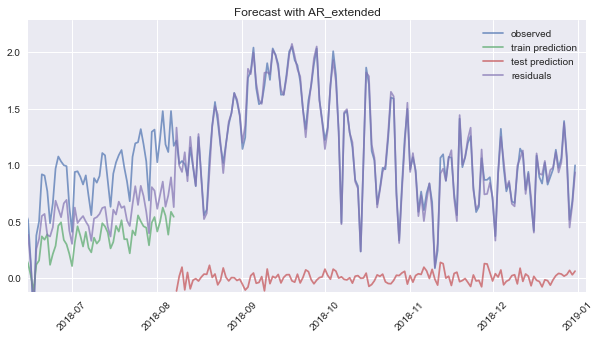

CPU times: total: 2min 44s
Wall time: 1min 4s


In [77]:
%%time
class AR_extended(ForecastingModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.tau = 1
        self.h_dim = 10
        self.gamma = 1
        self.lambda_f = 1
        self.lambda_g = 1/self.h_dim
        self.order = kwargs.get("order", 1)

    def model(self, zero_data, covariates):
        #x_E = X[:, :X_E.shape[1]]
        #x_W = X[:, -X_W.shape[1]:]

        duration, data_dim = zero_data.size()
        feature_dim = covariates.size(-1)

        # draw parameters
        gamma = pyro.sample("gamma", dist.HalfCauchy(self.tau).expand([1]).to_event(1))
        theta_g = pyro.sample("theta_g", dist.Normal(0,self.lambda_g).expand([self.h_dim]).to_event(1))
        theta_f = pyro.sample("theta_f", dist.Normal(0, self.lambda_f).expand([feature_dim, self.h_dim]).to_event(2))
        R = pyro.sample("R", dist.HalfCauchy(self.gamma).expand([self.h_dim]).to_event(1))

        
        with self.time_plate:         
            # print(covariates.unsqueeze(-1).shape, theta_f.shape)
            phi_hidden_mean = (theta_f*covariates.unsqueeze(-1)).sum(-2, keepdim=True).squeeze(-2)
            phi_hidden = pyro.sample("h", dist.Normal(phi_hidden_mean, R).to_event(1))

        phi = (theta_g*phi_hidden).sum(-1, keepdim=True)
        # print("phi", phi.shape, phi_hidden.shape)

        ys = []
        y = pyro.sample("y_0", dist.Normal(0, 1).expand([self.order]).to_event(1))
        ys.append(y)


        #y_plate = pyro.plate("y")
        for t in pyro.markov(range(duration), history = self.order):
            # y_mean = ys[t] + alpha @ X[t].unsqueeze(-1) + beta
            # phi = pyro.sample(f"phi_{t+1}", dist.Normal(0, 1).expand([self.order]).to_event(1))
            # print("phi", phi.shape, ys[t].shape, t)
            # print(phi.shape, phi[-2].shape, ys[t].shape)

            y_mean = ys[t] *phi[-2, t] if phi.ndim > 2 else ys[t] *phi[t]
            # y_mean = ys[t] * phi[t]
            y = pyro.sample(f"y_{t+1}", dist.Normal(y_mean, torch.ones_like(y_mean) * gamma).to_event(1))
            # print("y", y.shape, y_mean.shape)
            # y = y_mean
            ys.append(y)

        ys = torch.stack(ys[1:], dim=0)
        if ys.ndim > 2:
            ys = ys.squeeze(-1).permute(1,0,2)
        # print(ys.shape)
        pyro.deterministic("prediction", ys)
        #ys = ys.unsqueeze(-1)

        
        sigma = pyro.sample("sigma", dist.HalfCauchy(self.tau).expand([1]).to_event(1))

        noise_dist = dist.Normal(0, sigma)

        self.predict(noise_dist, ys)

# get forecaster
AR_extended_forecaster = train(AR_extended, num_steps=30, save=False, model_name="AR_extended", log_every = 1)
# forecaster = load_forecaster("AR")

# plot forecast
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
test_implementation(AR_extended_forecaster, start_idx = T1-50, ax = ax)
plt.show()


## Analyze posterior samples

In [91]:
# f = torch.load("models/test")

# sample_from_posterior(f)

sample_from_posterior("LinearDLM")

AssertionError: 

In [81]:
models = ["LinearDLM"]#, "LinearHiddenDLM", "AR1", "AR_extended"]

posterior_samples = {}
for model in models:
    with open(f"posterior_samples/{model}.pkl", "rb") as file:
        posterior_samples[model] = pickle.load(file)

posterior_samples

EOFError: Ran out of input

In [ ]:
# models = ["linear_dlm", "LinearHiddenDLM", "AR1", "AR_extended"]
# forecasters = [LinearDLM_forecaster, LinearHiddenDLM_forecaster, AR1_forecaster, AR_extended_forecaster]

# posterior_samples = {}

# for forecaster in forecasters:
#     # forecasters[model] = load_forecaster(model)
#     posterior_samples[forecaster.model.strip("()")] = sample_from_posterior(forecaster)



# forecasters = {model : load_forecaster(model) for model in models}
# posterior_samples = {model : sample_from_posterior(forecasters[model]) for model in models}

In [ ]:
# extract percentiles of the posterior samples
pred_p10, pred_p50, pred_p90 = quantile(posterior_samples['prediction'], (0.1, 0.5, 0.9)).squeeze(-1)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(dates, y, label="observed", alpha= .4)
ax.plot(dates[:T1], pred_p50[:T1], label="train prediction", alpha = .4)
ax.plot(dates[T1:], pred_p50[T1:], label="test prediction", alpha = .4)
ax.legend()

plt.setp(ax.get_xticklabels(), rotation = 45)

plt.show()

In [ ]:
resid = obs - posterior_samples['prediction'].squeeze()

resid_p10, resid_p50, resid_p90 = quantile(resid, (0.1, 0.5, 0.9)).squeeze(-1)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# ax.plot(dates, y, label="observed", alpha= .4)
ax.plot(dates[:T1], resid_p50[:T1], label="train prediction", alpha = .4)
ax.plot(dates[T1:], resid_p50[T1:], label="test prediction", alpha = .4)
# ax.fill_between(dates, resid_p10, resid_p90, color="red", alpha=0.3)
ax.legend()
ax.set_title("Residuals, mean abs residual: {:.2f}".format(resid.abs().mean()))

print("Mean price: ", obs.mean())
print("Mean abs residual: ", resid.abs().mean())
print("Mean abs train residual: ", resid[:, :T1].abs().mean())
print("Mean abs residual: ", resid[:, T1:].abs().mean())